<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and Imports

In [1]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar
import scipy.stats as stats

# Reproducbility Utilities

Note: We do not fix a single global seed. Each run is deterministic conditional to its seed for consistency testing.

In [3]:
def set_all_seeds(seed: int):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [4]:
def reset_tf():
  tf.keras.backend.clear_session()

# Data Loading

In [5]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [6]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [7]:
TARGET_1 = 'btc_logret'

In [8]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [9]:
TARGET_2 = 'btc_logret'

In [10]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [11]:
total_len = len(df)

In [12]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [13]:
train_df.shape

(2629, 29)

In [14]:
val_df.shape

(564, 29)

In [15]:
test_df.shape

(564, 29)

# Scaling

In [16]:
scaler_1 = MinMaxScaler()

In [17]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [18]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1 = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1 = scaler_1.transform(test_df[FEATURES_1])

In [19]:
scaler_2 = MinMaxScaler()

In [20]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [21]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2 = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2 = scaler_2.transform(test_df[FEATURES_2])

# LSTM Sequence Data

In [22]:
def make_sequence_data(values, target, lookback):
  X, y = [], []

  for i in range(lookback, len(values)):
    X.append(values[i - lookback: i])
    y.append(target[i])

  return np.array(X), np.array(y)

In [23]:
LOOKBACK = 60

In [24]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, train_df[TARGET_1].values, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, val_df[TARGET_1].values, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, test_df[TARGET_1].values, LOOKBACK)

X_train_2, y_train_2 = make_sequence_data(train_scaled_2, train_df[TARGET_2].values, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, val_df[TARGET_2].values, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, test_df[TARGET_2].values, LOOKBACK)

# Metrics

In [25]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)

  return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'DA': da}

# Modelling

In [26]:
from itertools import product

In [27]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.005],
    "batch_size": [32, 64],
    "dropout": [0.0, 0.2],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["dropout"],
    GRID["patience"]
))

In [28]:
len(grid_combinations)

32

In [29]:
def build_lstm(input_shape, units, dropout, learning_rate):
  model = models.Sequential([
      layers.LSTM(units, return_sequences=True, input_shape=input_shape),
      layers.LSTM(units),
      layers.Dropout(dropout),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
      loss='mse'
  )

  return model

In [30]:
results = []

In [ ]:
for i, (units, lr, batch_size, dropout, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, batch={batch_size}, "
        f"dropout={dropout}, patience={patience}")

  # WITHOUT MACRO
  model_1 = build_lstm(X_train_1.shape[1:], units, dropout, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_1, y_val_1),
      callbacks = [
          tf.keras.callbacks.EarlyStopping(patience = patience, restore_best_weights = True)
      ],
      verbose = 0
  )

  y_pred_1 = model_1.predict(X_test_1).ravel()
  metrics_1 = calculate_performance_metrics(y_test_1, y_pred_1)

  # WITH MACRO
  model_2 = build_lstm(X_train_2.shape[1:], units, dropout, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_2, y_val_2),
      callbacks = [
          tf.keras.callbacks.EarlyStopping(patience = patience, restore_best_weights = True)
      ],
      verbose = 0
  )

  y_pred_2 = model_2.predict(X_test_2).ravel()
  metrics_2 = calculate_performance_metrics(y_test_2, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "dropout": dropout,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })



[1/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[2/32] units=50, lr=0.001, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[3/32] units=50, lr=0.001, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

[4/32] units=50, lr=0.001, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

[5/32] units=50, lr=0.001, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[6/32] units=50, lr=0.001, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

[7/32] units=50, lr=0.001, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[8/32] units=50, lr=0.001, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

[9/32] units=50, lr=0.005, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

[10/32] units=50, lr=0.005, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[11/32] units=50, lr=0.005, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[12/32] units=50, lr=0.005, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[13/32] units=50, lr=0.005, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[14/32] units=50, lr=0.005, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

[15/32] units=50, lr=0.005, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[16/32] units=50, lr=0.005, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

[17/32] units=100, lr=0.001, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[18/32] units=100, lr=0.001, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[19/32] units=100, lr=0.001, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

[20/32] units=100, lr=0.001, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

[21/32] units=100, lr=0.001, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[22/32] units=100, lr=0.001, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

[23/32] units=100, lr=0.001, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

[24/32] units=100, lr=0.001, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

[25/32] units=100, lr=0.005, batch=32, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[26/32] units=100, lr=0.005, batch=32, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

[27/32] units=100, lr=0.005, batch=32, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[28/32] units=100, lr=0.005, batch=32, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

[29/32] units=100, lr=0.005, batch=64, dropout=0.0, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[30/32] units=100, lr=0.005, batch=64, dropout=0.0, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step

[31/32] units=100, lr=0.005, batch=64, dropout=0.2, patience=5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

[32/32] units=100, lr=0.005, batch=64, dropout=0.2, patience=10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


# Optimized Configs

In [33]:
results_df = pd.DataFrame(results)

In [34]:
results_df

""


In [ ]:
results_df.to_csv('lstm_grid_results.csv')

In [ ]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [ ]:
best_without_macro

,6
units,50
learning_rate,0.001
batch_size,64
dropout,0.2
patience,5
MSE_1,0.000559
MSE_2,0.000621
RMSE_1,0.023641
RMSE_2,0.024926
MAE_1,0.016903


In [ ]:
best_with_macro

,18
units,100
learning_rate,0.001
batch_size,32
dropout,0.2
patience,5
MSE_1,0.000562
MSE_2,0.000557
RMSE_1,0.023705
RMSE_2,0.023608
MAE_1,0.016997


In [35]:
LSTM_1 = dict(units=50, lr=0.001, batch=64, dropout=0.2, patience=5)
LSTM_2 = dict(units=100, lr=0.001, batch=32, dropout=0.2, patience=5)

# Model Training

In [36]:
def train_and_predict(Xtr, ytr, Xv, yv, Xte, config, seed):
  set_all_seeds(seed)
  reset_tf()

  model = models.Sequential([
      layers.LSTM(config['units'], return_sequences=True, input_shape=Xtr.shape[1:]),
      layers.LSTM(config['units']),
      layers.Dropout(config['dropout']),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(config['lr']),
      loss='mse'
  )

  history = model.fit(
      Xtr, ytr,
      epochs=50,
      batch_size=config['batch'],
      validation_data=(Xv, yv),
      callbacks=[
          tf.keras.callbacks.EarlyStopping(patience=config['patience'], restore_best_weights=True)
      ],
      verbose=1
  )

  return model.predict(Xte).ravel(), history

# Replicate Training

In [37]:
SEEDS = [41, 42, 43]

rows = []
all_err_1, all_err_2 = [], []
rep_predictions = {}

In [38]:
for seed in SEEDS:
  yhat_1, history_1 = train_and_predict(
      X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, LSTM_1, seed
  )

  yhat_2, history_2 = train_and_predict(
      X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, LSTM_2, seed
  )

  rep_predictions[seed] = {
      'yhat_1': yhat_1,
      'yhat_2': yhat_2
  }

  # Significance Testing

  loss_diff = (y_test_2 - yhat_2)**2 - (y_test_1 - yhat_1)**2
  X = np.ones(len(loss_diff))
  hac = sm.OLS(loss_diff, X).fit(
      cov_type='HAC', cov_kwds={'maxlags': 5}
  )

  correct_1 = np.sign(y_test_1) == np.sign(yhat_1)
  correct_2 = np.sign(y_test_2) == np.sign(yhat_2)

  table = [
      [np.sum(correct_1 & correct_2), np.sum(~correct_1 & correct_2)],
      [np.sum(correct_1 & ~correct_2), np.sum(~correct_1 & ~correct_2)]
  ]

  mcn = mcnemar(table, correction=True)

  # WMAE and Distributions
  prev_price = test_df['btc_price'].iloc[LOOKBACK-1:-1].values
  actual = test_df['btc_price'].iloc[LOOKBACK:].values

  pred_1 = prev_price * np.exp(yhat_1)
  pred_2 = prev_price * np.exp(yhat_2)

  err_1 = pred_1 - actual
  err_2 = pred_2 - actual

  all_err_1.append(err_1)
  all_err_2.append(err_2)

  vol = pd.Series(test_df['btc_logret'].iloc[LOOKBACK:].values).rolling(60).std().values
  idx = ~np.isnan(vol)

  wmae_1 = np.sum(np.abs(err_1[idx]) * vol[idx]) / np.sum(vol[idx])
  wmae_2 = np.sum(np.abs(err_2[idx]) * vol[idx]) / np.sum(vol[idx])

  rows.append({
      "model": "LSTM",
      "seed": seed,
      "hac_p": hac.pvalues[0],
      "hac_mean_diff": hac.params[0],
      "mcnemar_p": mcn.pvalue,
      "wmae_no_macro": wmae_1,
      "wmae_macro": wmae_2,
      "delta_wmae": wmae_2 - wmae_1
  })

results_df = pd.DataFrame(rows)
results_df.to_csv('lstm_statistical_results.csv', index=False)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0020 - val_loss: 6.2014e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0017 - val_loss: 6.1697e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0017 - val_loss: 6.0345e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.0346e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.1108e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0017 - val_loss: 6.0183e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.0395e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.0573e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.0788e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0017 - val_loss: 6.0433e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0017 - val_loss: 6.1591e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0028 - val_loss: 9.0446e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0017 - val_loss: 6.1384e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0017 - val_loss: 6.1537e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0017 - val_loss: 6.0307e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0017 - val_loss: 6.2181e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0017 - val_loss: 6.3747e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0017 - val_loss: 6.0392e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0017 - val_loss: 6.2187e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0016 - val_loss: 6.1425e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0039 - val_loss: 6.0210e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0017 - val_loss:

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0023 - val_loss: 6.4936e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0016 - val_loss: 6.4984e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0016 - val_loss: 6.8262e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0016 - val_loss: 7.5667e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0016 - val_loss: 6.6983e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0016 - val_loss: 7.3354e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - loss: 0.0047 - val_loss: 6.4877e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0016 - val_loss: 7.1272e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0016 - val_loss: 7.1047e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0016 - val_loss: 6.0795e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0015 - val_loss

In [39]:
results_df

,model,seed,hac_p,hac_mean_diff,mcnemar_p,wmae_no_macro,wmae_macro,delta_wmae
0,LSTM,41,6.123562e-01,-0.000003,0.861146,1525.660308,1523.979762,-1.680546
1,LSTM,42,2.154495e-13,-0.000259,0.931708,2074.795560,1526.439944,-548.355616
2,LSTM,43,1.827164e-03,-0.000050,0.670316,1643.318301,1540.471896,-102.846405


# Error Diagnostics

In [40]:
all_err_1 = np.concatenate(all_err_1)
all_err_2 = np.concatenate(all_err_2)

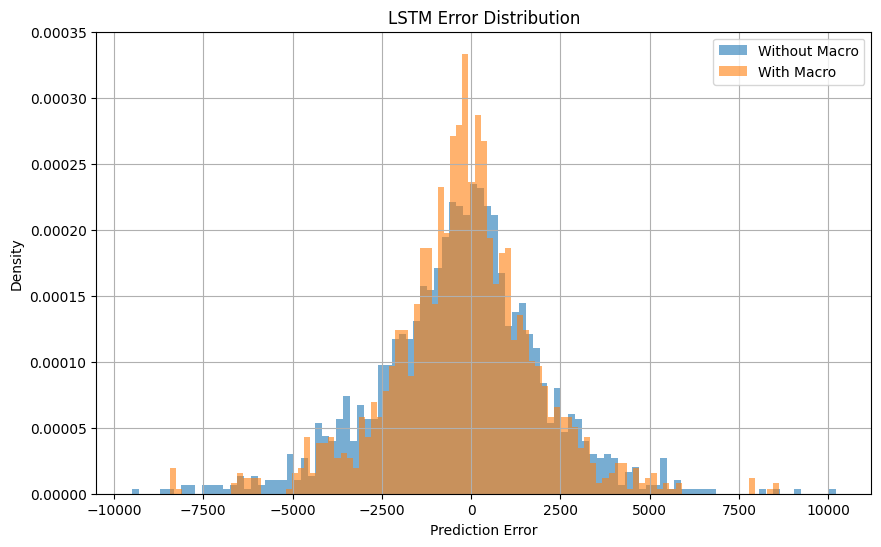

In [41]:
plt.figure(figsize=(10,6))
plt.hist(all_err_1, bins=100, alpha=0.6, density=True, label="Without Macro")
plt.hist(all_err_2, bins=100, alpha=0.6, density=True, label="With Macro")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("LSTM Error Distribution")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-70046455.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


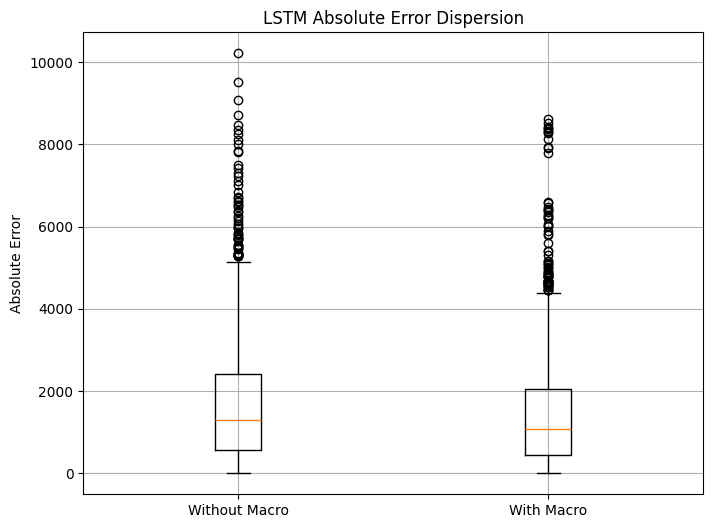

In [44]:
plt.figure(figsize=(8,6))
plt.boxplot(
    [np.abs(all_err_1), np.abs(all_err_2)],
    labels=["Without Macro", "With Macro"],
    showfliers=True
)
plt.ylabel("Absolute Error")
plt.title("LSTM Absolute Error Dispersion")
plt.grid(True)
plt.show()

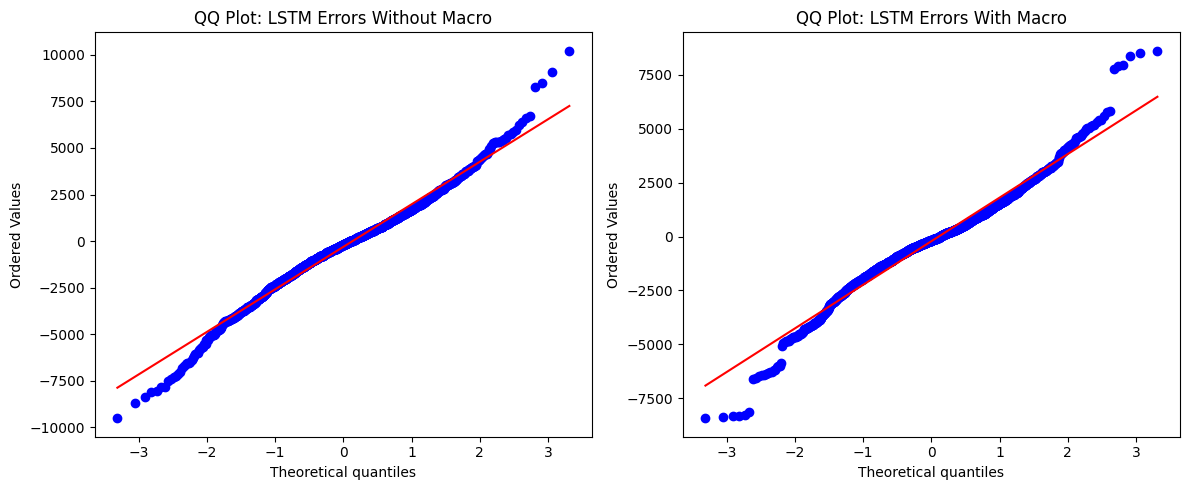

In [43]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
stats.probplot(all_err_1, dist="norm", plot=plt)
plt.title("QQ Plot: LSTM Errors Without Macro")

plt.subplot(1,2,2)
stats.probplot(all_err_2, dist="norm", plot=plt)
plt.title("QQ Plot: LSTM Errors With Macro")

plt.tight_layout()
plt.show()